In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import brewer2mpl
import colorsys
import math
import dendropy as dp
import json
import os

from datetime import datetime
from Bio import AlignIO, SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio.Align.Applications import ClustalOmegaCommandline 
from Levenshtein import distance
from itertools import combinations, product, permutations
from time import time
from __future__ import division
from collections import Counter, defaultdict
from copy import deepcopy
from random import shuffle, choice, sample
from scipy.stats.mstats import mquantiles
from scipy.stats import norm, expon, poisson, binom
from scipy.misc import comb
from IPython.display import Math
from networkx.readwrite import json_graph 

%matplotlib inline

In [2]:
# # Uncomment this if you need to re-run the notebook.
# G = nx.read_gpickle('20141103 All IRD Parallel Transmission Graph Non-Same Subtypes Removed.pkl')

# subgraphs = [g for g in nx.connected_component_subgraphs(G.to_undirected())]

#### OTHERWISE: RUN THE FOLLOWING CELL ####

In [62]:
subgraphs = dict()
for f in os.listdir('{0}/subgraph_pkl'.format(os.getcwd())):
    idx = int(f.split(' ')[0])
    g = nx.read_gpickle('subgraph_pkl/{0}'.format(f))
    subgraphs[idx] = g

(array([ 690.,    0.,    1.,    1.,    0.,    0.,    0.,    1.,    0.,    1.]),
 array([  1.00000000e+00,   3.56300000e+02,   7.11600000e+02,
          1.06690000e+03,   1.42220000e+03,   1.77750000e+03,
          2.13280000e+03,   2.48810000e+03,   2.84340000e+03,
          3.19870000e+03,   3.55400000e+03]),
 <a list of 10 Patch objects>)

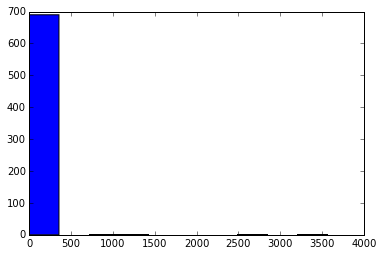

In [8]:
plt.hist([len(g.nodes()) for g in subgraphs])

In [9]:
# for i, g in enumerate(subgraphs):
#     node0 = g.nodes()[0]
    
#     subtype = g.node[node0]['subtype']
#     if subtype == 'H3N2':
#         print(subgraphs[i].nodes()[0])

In [10]:
ha_data = pd.read_csv('20150112_All_IRD_HA_Sequences.csv', parse_dates=['Collection Date'])
ha_data['Sequence Accession'] = ha_data['Sequence Accession'].str.replace('*', '')
ha_data['Strain Name'] = ha_data['Strain Name'].apply(lambda x: x.split('(')[0] if '(' in x else x)

In [11]:
accession_strain = dict(zip(ha_data['Sequence Accession'], ha_data['Strain Name']))
accession_year = dict(zip(ha_data['Sequence Accession'], ha_data['Collection Date'].apply(lambda x: x.year)))
accession_host = dict(zip(ha_data['Sequence Accession'], ha_data['Host Species'].str.split(':').str[1]))
strain_accession = defaultdict(list)
for a, s in accession_strain.items():
    strain_accession[s].append(a)

In [12]:
len(subgraphs[0].nodes())

356

In [13]:
# # Uncomment this if you need to re-run the notebook.
# # Load the FASTA file into memory.
# ha_sequences = SeqIO.to_dict(SeqIO.parse('20150112_All_IRD_HA_Sequences.fasta', 'fasta'))
# ha_sequences

In [14]:
# # Uncomment this if you need to re-run the notebook.
# # Write FASTA files by subgraphs.
# for i, g in enumerate(subgraphs):
#     nodes = g.nodes()
#     sequences_to_write = dict()
#     for node in nodes:
#         accessions = strain_accession[node]
#         for accession in accessions:
#             sequences_to_write[accession] = ha_sequences[accession]
            
#     lengths = [len(seqrecord.seq) for seqrecord in sequences_to_write.values()]
#     length_counts = Counter(lengths)
#     print(i, length_counts)
#     with open('subgraph_ha_fasta/{0}_HA_Sequences.fasta'.format(i), 'w+') as f:
#         SeqIO.write(sequences_to_write.values(), f, 'fasta')

In [15]:
# # Uncomment this if you need to re-run the notebook.
# # Write SGE scripts for clustal omega alignments.
# if 'clustal_omega_scripts' not in os.listdir(os.getcwd()):
#     os.mkdir('clustal_omega_scripts')
    
# header = '\
# #!/bin/sh \n\
# #$ -S /bin/sh \n\
# #$ -cwd \n\
# #$ -V\n\
# #$ -m e\n\
# #$ -M ericmjl@mit.edu \n\
# #$ -pe whole_nodes 1\n\
# #############################################\n \n\
# '
# with open('clustal_omega_scripts/clustalo.sh', 'w+') as master:
    
#     master.write(header)

#     for i, g in enumerate(subgraphs):
#         if len(g.nodes()) > 1:
#             in_file = '{0}_HA_Sequences.fasta'.format(i)
#             out_file = '{0}_HA_Sequences_Aligned.fasta'.format(i)

#             cline = str(ClustalOmegaCommandline(infile=in_file, outfile=out_file, verbose=True, auto=True))

#             with open('clustal_omega_scripts/clustalo_{0}.sh'.format(i), 'w+') as f:
#                 f.write(header)
#                 f.write(cline)
#                 f.write('\n')
                
#             master.write('qsub clustalo_{0}.sh\n'.format(i))
            
        
        

In [16]:
pkas = {
    'A':7.0,
    'R':12.48,
    'N':7.0,
    'D':3.90,
    'C':8.37,
    'E':4.70,
    'Q':7.0,
    'G':7.0,
    'H':6.04,
    'I':7.0,
    'L':7.0,
    'K':10.54,
    'M':7.0,
    'F':7.0,
    'P':7.0,
    'S':7.0,
    'T':7.0,
    'W':7.0,
    'Y':10.46,
    'V':7.0,
    'X':7.0,
    '-':7.0,
    'B':6.33, # B = asp or asn, average pka is 6.33
    'J':7.0 # J = leu or ile, pka is 7
}

In [41]:
mws = {
	'A':89.0935,
	'R':174.2017,
	'N':132.1184,
	'D':133.1032,
	'C':121.1590,
	'E':147.1299,
	'Q':146.1451,
	'G':75.0669,
	'H':155.1552,
	'I':131.1736,
    'J':131.1736,
	'L':131.1736,
	'K':146.1882,
	'M':149.2124,
	'F':165.1900,
	'P':115.1310,
	'S':105.0930,
	'T':119.1197,
	'W':204.2262,
	'Y':181.1894,
	'V':117.1469,
    'X':0,
    '-':0,
    'B':132.61395 #average weight of asp or asn
}

In [159]:
for f in os.listdir('subgraph_ha_aligned'):
    print(int(f.split('_')[0]))

0
101
106
107
108
109
10
110
111
112
113
114
115
116
117
118
11
121
122
123
124
125
126
127
128
129
12
130
131
132
133
134
135
136
138
139
13
141
142
144
145
146
147
148
149
14
150
152
153
154
155
156
157
158
15
160
161
162
163
164
165
166
167
168
16
170
171
172
174
176
178
179
17
180
182
183
184
186
187
188
189
18
190
192
193
194
195
196
197
198
199
19
1
200
202
203
204
206
209
20
212
214
215
218
219
21
220
221
222
223
224
226
227
228
229
22
231
233
234
236
238
239
23
241
248
24
250
252
255
256
258
25
260
261
262
263
264
265
267
26
272
275
276
278
279
27
283
285
286
289
28
290
298
299
29
2
301
302
304
307
30
312
316
317
318
319
31
320
322
325
327
328
329
32
330
331
332
333
336
338
339
33
340
342
343
350
351
354
359
35
360
364
365
368
36
370
373
376
37
383
388
389
390
391
392
394
396
397
399
39
3
400
401
406
407
40
412
416
41
420
423
424
426
42
430
431
433
439
43
443
445
447
44
450
45
464
466
46
479
47
480
488
489
48
492
493
494
495
499
49
4
501
502
504
507
50
516
51
522
523
52
530
537

In [152]:
idx = 4
print(Counter([d['subtype'] for n, d in subgraphs[idx].nodes(data=True)]))
print(Counter([d['host'] for n, d in subgraphs[idx].nodes(data=True)]))
print(Counter([d['collection_date'].year for n, d in subgraphs[idx].nodes(data=True)]))

Counter({'H3N2': 3554})
Counter({'Human': 3551, 'Swine': 2, 'Dog': 1})
Counter({2013: 478, 2012: 474, 2010: 324, 2009: 245, 2007: 228, 2003: 224, 2011: 213, 2004: 209, 2005: 192, 2008: 176, 2002: 136, 1999: 118, 2000: 108, 1993: 85, 2006: 72, 2001: 41, 1991: 34, 1996: 31, 1998: 27, 1992: 25, 1994: 24, 1995: 24, 1997: 20, 1989: 13, 1988: 7, 1985: 6, 1983: 4, 1986: 4, 1990: 4, 1980: 2, 1981: 2, 1982: 2, 1984: 2})


In [153]:
def alignment_as_dataframe(handle):
    sequences = [s for s in SeqIO.parse(handle, 'fasta')]
    alignment = pd.DataFrame(np.array([seq for seq in sequences]))
    idx = [seq.id for seq in sequences]
    alignment.index = idx
    
    return alignment

alignment = alignment_as_dataframe('subgraph_ha_aligned/{0}_HA_Sequences_Aligned.fasta'.format(idx))
alignment

,0,1,2,3,4,5,6,7,8,9,...,556,557,558,559,560,561,562,563,564,565
CY160952,M,K,T,I,I,A,L,S,Y,I,...,K,G,N,I,R,C,N,I,C,I
CY169839,M,K,T,I,I,A,L,S,Y,I,...,K,G,N,I,R,C,N,I,C,I
CY160480,M,K,T,I,I,A,L,S,Y,I,...,K,G,N,I,R,C,N,I,C,I
CY113373,M,K,T,I,I,A,L,S,Y,I,...,K,G,N,I,R,C,N,I,C,I
CY160488,M,K,T,I,I,A,L,S,Y,I,...,K,G,N,I,R,C,N,I,C,I
CY068822,M,K,T,I,I,A,L,S,Y,I,...,K,G,N,I,R,C,N,I,C,I
CY007955,M,K,T,I,I,A,L,S,Y,I,...,K,G,N,I,R,C,N,I,C,I
CY098081,M,K,T,I,I,A,L,S,Y,I,...,K,G,N,I,R,C,N,I,C,I
CY188521,M,K,T,I,I,A,L,S,Y,I,...,K,G,N,I,R,C,N,I,C,I
CY003256,M,K,T,I,I,A,L,S,Y,I,...,K,G,N,I,R,C,N,I,C,I


In [154]:
np.unique(alignment.values)

array(['-', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M',
       'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X', 'Y'], dtype=object)

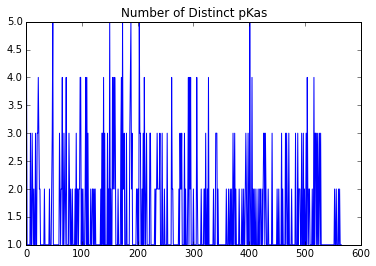

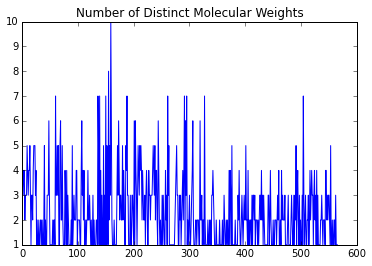

,1,2,3,4,5,6,7,8,9,10,...,547,548,549,550,551,553,556,559,560,562
CY160952,146.1882,119.1197,131.1736,131.1736,89.0935,131.1736,105.093,181.1894,131.1736,131.1736,...,131.1736,75.0669,165.19,131.1736,149.2124,89.0935,146.1882,131.1736,174.2017,132.1184
CY169839,146.1882,119.1197,131.1736,131.1736,89.0935,131.1736,105.093,181.1894,131.1736,131.1736,...,131.1736,75.0669,165.19,131.1736,149.2124,89.0935,146.1882,131.1736,174.2017,132.1184
CY160480,146.1882,119.1197,131.1736,131.1736,89.0935,131.1736,105.093,181.1894,131.1736,131.1736,...,131.1736,75.0669,165.19,131.1736,149.2124,89.0935,146.1882,131.1736,174.2017,132.1184
CY113373,146.1882,119.1197,131.1736,131.1736,89.0935,131.1736,105.093,181.1894,131.1736,165.1900,...,131.1736,75.0669,165.19,131.1736,149.2124,89.0935,146.1882,131.1736,174.2017,132.1184
CY160488,146.1882,119.1197,131.1736,131.1736,89.0935,131.1736,105.093,181.1894,131.1736,131.1736,...,131.1736,75.0669,165.19,131.1736,149.2124,89.0935,146.1882,131.1736,174.2017,132.1184
CY068822,146.1882,119.1197,131.1736,131.1736,89.0935,131.1736,105.093,181.1894,131.1736,131.1736,...,131.1736,75.0669,165.19,131.1736,149.2124,89.0935,146.1882,131.1736,174.2017,132.1184
CY007955,146.1882,119.1197,131.1736,131.1736,89.0935,131.1736,105.093,181.1894,131.1736,131.1736,...,131.1736,75.0669,165.19,131.1736,149.2124,89.0935,146.1882,131.1736,174.2017,132.1184
CY098081,146.1882,119.1197,131.1736,131.1736,89.0935,131.1736,105.093,181.1894,131.1736,131.1736,...,131.1736,75.0669,165.19,131.1736,149.2124,89.0935,146.1882,131.1736,174.2017,132.1184
CY188521,146.1882,119.1197,131.1736,131.1736,89.0935,131.1736,105.093,181.1894,131.1736,131.1736,...,131.1736,75.0669,165.19,131.1736,149.2124,89.0935,146.1882,131.1736,174.2017,132.1184
CY003256,146.1882,119.1197,131.1736,131.1736,89.0935,131.1736,105.093,181.1894,131.1736,131.1736,...,131.1736,75.0669,165.19,131.1736,149.2124,89.0935,146.1882,131.1736,174.2017,132.1184


In [155]:
def make_biochemical_alignment(alignment, bioc_mapping_dict, bioc_str):
    bioc_alignment = alignment.copy()
    bioc_alignment.replace(bioc_mapping_dict.keys(), bioc_mapping_dict.values(), inplace=True)
    
#     print(bioc_alignment)
    
    num_distinct_bioc = []
    positions_only_one_bioc = []

    for column in bioc_alignment.columns:
        bioc_values = Counter(bioc_alignment[column].values)

        if len(bioc_values.keys()) == 1:
            positions_only_one_bioc.append(column)

        num_distinct_bioc.append(len(bioc_values.keys()))

    plt.plot(num_distinct_bioc)
    plt.title('Number of Distinct {0}'.format(bioc_str))
    plt.show()
    
    bioc_alignment_cleaned = bioc_alignment.copy()
    bioc_alignment_cleaned.drop(positions_only_one_bioc, axis=1, inplace=True)
    
    return bioc_alignment_cleaned

pka_alignment = make_biochemical_alignment(alignment, pkas, 'pKas')
pka_alignment

mw_alignment = make_biochemical_alignment(alignment, mws, 'Molecular Weights')
mw_alignment

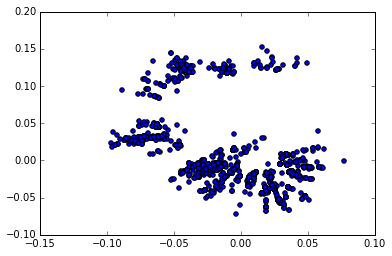

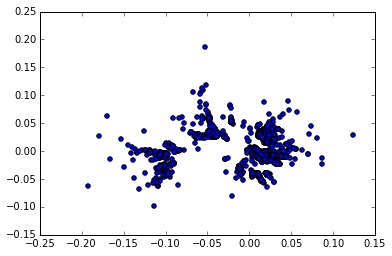

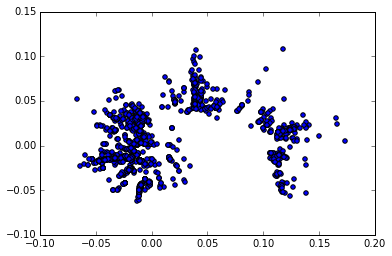

In [156]:
def perform_mds(bioc_correlation_matrix, bioc_str):
    from sklearn.manifold import MDS
    mds = MDS(dissimilarity='precomputed', n_jobs=-1)
    coords = mds.fit_transform(1 - bioc_correlation_matrix)
    
    coords_df = pd.DataFrame(coords)
    coords_df.index = bioc_correlation_matrix.index
    coords_df.columns = ['x', 'y']
    
    return coords_df


# fig = plt.figure(0)
mds_coordinates_pka = perform_mds(pka_alignment.T.corr(), 'pKas')
# plt.scatter(mds_coordinates_pka['x'], mds_coordinates_pka['y'])
mds_coordinates_pka.to_csv(')

# fig = plt.figure(1)
mds_coordinates_mw = perform_mds(mw_alignment.T.corr(), 'MWs')
# plt.scatter(mds_coordinates_mw['x'], mds_coordinates_mw['y'])

# fig = plt.figure(2)
avg_alignment = (mw_alignment.T.corr() + pka_alignment.T.corr())/2 
mds_coordinates_avg = perform_mds(avg_alignment, 'Average')
# plt.scatter(mds_coordinates_avg['x'], mds_coordinates_avg['y'])